# Optimization test

In [39]:
import glob
import json
import os

import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

import matplotlib.pyplot as plt
#import seaborn as sns

### Import data

In [25]:
dir_wc = '../multirun/2020-12-26/19-54-29/*'

# Read
data_paths_list = glob.glob(f'{dir_wc}/data.json')

# Parse into dict
Paths_dict = {}
for e in data_paths_list:
    Paths_dict[e.split('/')[-2]] = e

Paths_dict

{'0': '../multirun/2020-12-26/19-54-29/0/data.json',
 '1': '../multirun/2020-12-26/19-54-29/1/data.json',
 '3': '../multirun/2020-12-26/19-54-29/3/data.json',
 '2': '../multirun/2020-12-26/19-54-29/2/data.json'}

In [26]:
Data_dict = {}

for k in Paths_dict:
    with open(Paths_dict[k]) as infile:
        Data_dict[k] = json.load(infile)

print(len(Data_dict))

4


## Optimize Feature Matrix for one run

In [27]:
Data_dict['0'].keys()

dict_keys(['config_dict', 'env_kwargs', 'training_data'])

### Utility functions

In [209]:
def extract_known_parameters(ddict):
    """
    Given the data dict for a single training run.
    Assume offline TD(0) updates
    """
    
    # Transition and feature matrices
    transMat = np.array(
        ddict['env_kwargs']['transition_mat']
    )
    
    featMat = np.array(
        ddict['env_kwargs']['feature_mat']
    ) # ground truth
    
    # Error matrix
    errMat = np.array(
        ddict['training_data']['td_errors']
    )
    
    n_states = ddict['config_dict']['environment']['generator']['kwargs']['n_states']
    
    # Training parameters
    gamma = ddict['config_dict']['agent']['kwargs']['gamma']
    lamb = ddict['config_dict']['agent']['kwargs']['lamb']
    lr = ddict['config_dict']['agent']['kwargs']['lr']
    
    
    out_dict = {
        'transMat': transMat,
        'featMat': featMat,
        'feature_dim': np.shape(featMat)[1],
        'errMat': errMat,
        'n_states': n_states,
        'gamma': gamma,
        'lamb': lamb,
        'lr': lr,
    }
    
    return out_dict

tabu_infoDict = extract_known_parameters(Data_dict['2'])
tabu_infoDict.keys()

dict_keys(['transMat', 'featMat', 'feature_dim', 'errMat', 'n_states', 'gamma', 'lamb', 'lr'])

In [210]:
def gen_optim_dataset(in_errMat):
    """
    Generate the training data given a matrix of errors
    """
    # 
    errMat = np.copy(in_errMat)
    
    # Dims and init
    M_ds = sum([n for n in range(1, (len(errMat)))])
    T_ds = np.shape(errMat)[1]
    
    errDiffMat = np.zeros((M_ds, T_ds))
    errSumMat = np.zeros((M_ds, T_ds))
    
    # Generate dataset
    counter_idx = 0
    for i in range(len(errMat)-1):
        cumuErrVec = errMat[i,:]
        for j in range(i+1, len(errMat)):
            
            curErrDiff = errMat[j,:] - errMat[i,:]
            errDiffMat[counter_idx,:] = curErrDiff
            
            errSumMat[counter_idx,:] = cumuErrVec
            cumuErrVec += errMat[j, :]
        
            counter_idx += 1
    
    return errDiffMat, errSumMat
    
# Test 
tmpdiff, tmpsum = gen_optim_dataset(tabu_infoDict['errMat'])
print(tmpdiff.shape)
print(tmpsum.shape)

(91, 10)
(91, 10)


## Old ref

In [211]:
def err_diff_fn(phiMat, errSumVec, obs_dict):
    """For computing the TD error difference"""
    
    n_obs_states = obs_dict['n_states']-1  # TODO hacky?
    
    cp_errSumVec = jnp.array(errSumVec)
    
    # Left side matrix
    alpha = obs_dict['lr']
    gamma = obs_dict['gamma']
    trMat = obs_dict['transMat']
    
    lefMat = alpha * (gamma * trMat - np.identity(len(trMat)))
    lefMat = lefMat[:n_obs_states, :n_obs_states]  # TODO not sure if correct
    
    # 
    outerPhi = jnp.dot(phiMat, phiMat.T)
    
    return jnp.dot(jnp.dot(lefMat, outerPhi), cp_errSumVec)

def loss(phiMat, errSumVec, targetVec, obs_dict):
    """MSE loss function for a given sample"""
    cp_errSumVec = jnp.array(errSumVec)
    cp_targetVec = jnp.array(targetVec)
    predVec = err_diff_fn(phiMat, cp_errSumVec, obs_dict)
    return jnp.mean(jnp.square((cp_targetVec - predVec)))
    

# Test above with the first two days
tmp_phiMat = jnp.array(np.copy(tabu_infoDict['featMat'][:10]))
print(np.sum(tabu_infoDict['featMat']))
print(np.sum(tabu_infoDict['errMat']))


loss(
    tmp_phiMat,
    tabu_infoDict['errMat'][0],
    (tabu_infoDict['errMat'][1] - tabu_infoDict['errMat'][0]),
    tabu_infoDict,
)

12.738422525603852
4.551318066837886


DeviceArray(6.373076e-17, dtype=float32)

In [212]:
def init_phi_params(state_dim, feature_dim=4):
    """Initialization"""
    rgenkey = random.PRNGKey(1)
    mat = random.uniform(rgenkey, shape=(state_dim, feature_dim), 
                         #minval=-1e-3, maxval=1e-3
                        )
    return mat


# Testing
tmp_rand = init_phi_params(
    (tabu_infoDict['n_states']-1),
    feature_dim=4,
)
print(tmp_rand.shape)
print(tmp_rand.sum())

(10, 4)
19.953606


### Optimization

**NOTE** Seems like it is being computed, but it just explodes to NaN / Inf after one step, not sure how to fix this yet

In [213]:
list(tabu_infoDict)

['transMat',
 'featMat',
 'feature_dim',
 'errMat',
 'n_states',
 'gamma',
 'lamb',
 'lr']

In [215]:
def script_optimize(infoDict):
    
    # ==
    # Get the target matrix
    eDiffMat, eSumMat = gen_optim_dataset(infoDict['errMat'])
    
    # ==
    # Define loss and gradient function
    def loss_fn(phiMat, errSumVec, targetVec):
        return loss(phiMat, errSumVec, targetVec, infoDict)
    
    def sum_loss_fn(phiMat, errSumBatch, targetBatch):
        loss_vec_fn = vmap(loss_fn, in_axes=(None, 0, 0), out_axes=0)
        return jnp.average(loss_vec_fn(phiMat, errSumBatch, targetBatch))
    
    loss_grad = grad(sum_loss_fn)
    
    # ==
    # Initialize
    
    phi_param = init_phi_params(state_dim=10, feature_dim=10)
    print('phi_param sum', np.sum(phi_param))
    
    
    loss_grad(phi_param, eSumMat, eDiffMat)
    
    # ==
    N_iterations = 1000
    lr = 1.0
    momentum_constant = 0.99
    
    """
    #  Try to do this for one sample only
    loss_grad = grad(loss)
    for nth_iter in range(10):
        cur_loss = loss(phi_param, eSumMat[0], eDiffMat[0], infoDict)
        print(f'Iteration: {nth_iter}, Loss: {cur_loss}')
        
        g_loss = loss_grad(phi_param, eSumMat[0], eDiffMat[0], infoDict)
        #phi_param = phi_param - (lr * (g_loss / jnp.linalg.norm(g_loss)))
        phi_param = phi_param - (lr * g_loss)    
    
    return phi_param
    
    a = 1/0
    """
    
    cur_velocity = 0.0

    for nth_iter in range(N_iterations):
        cur_loss = sum_loss_fn(phi_param, eSumMat, eDiffMat)
        
        if nth_iter % 200 == 0:
            print(f'Iteration: {nth_iter}, Loss: {cur_loss}')
        
        g_loss = loss_grad(phi_param, eSumMat, eDiffMat)
        
        delta_param = cur_velocity * momentum_constant + (lr * (g_loss))
        phi_param = phi_param - delta_param
    
    return phi_param
    s
tmp_out_phi = script_optimize(tabu_infoDict)


tmp_out_phi

phi_param sum 48.830673
Iteration: 0, Loss: 0.30845528841018677
Iteration: 200, Loss: 0.01691681519150734
Iteration: 400, Loss: 0.015525865368545055
Iteration: 600, Loss: 0.0151614248752594
Iteration: 800, Loss: 0.014980372041463852


DeviceArray([[-0.16083322,  0.26377058, -0.0463172 ,  0.08878258,
               1.0131717 ,  0.9405479 , -0.20294406,  0.953471  ,
               0.76166165,  0.62235713],
             [ 0.17507206,  0.6926856 ,  0.20415334,  0.45586967,
               0.5265354 ,  1.00235   , -0.03923352,  0.07313479,
               1.3069204 ,  0.2956203 ],
             [ 0.22271147, -0.09616927,  0.6112591 ,  0.38033777,
               0.57313645,  0.986961  ,  0.4520119 ,  0.82539296,
               1.08899   ,  0.94666624],
             [ 0.20328493,  0.7921298 ,  0.61061776,  1.1591036 ,
               0.50731057,  1.0323274 ,  0.24312468,  0.9374667 ,
               0.58087736,  0.5701187 ],
             [ 0.7525608 ,  0.76868975,  1.0124578 ,  0.9925539 ,
               0.81090564,  0.5506086 ,  0.7875763 ,  0.2098647 ,
               0.8821291 ,  0.5257813 ],
             [ 0.5087428 ,  1.0593618 ,  0.8730648 ,  0.97107595,
               0.6490517 ,  0.02813849,  1.4452436 ,  0.8292674 ,
   

(10, 10)


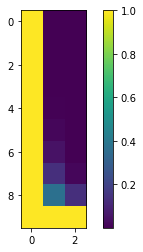

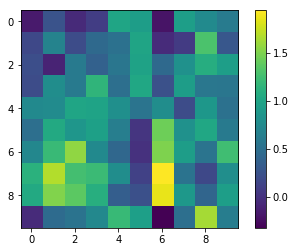

In [216]:

tmp = np.array(tmp_out_phi)
print(tmp.shape)

tmp2 = np.copy(tabu_infoDict['featMat'][0:-1])

plt.imshow(tmp2)
plt.colorbar()
plt.show()

plt.imshow(tmp)
plt.colorbar()
plt.show()

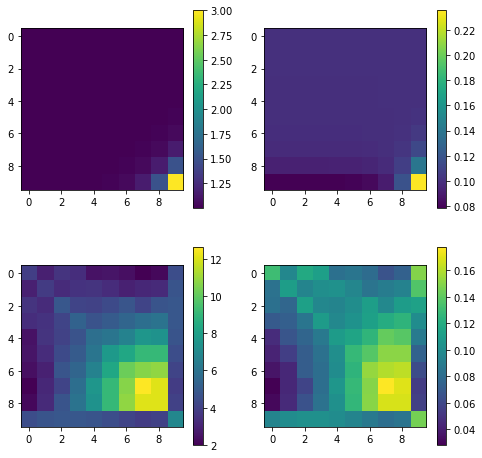

In [227]:
tmp_outerA = tmp2 @ tmp2.T  # real feature
tmp_outerB = tmp @ tmp.T

plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
plt.imshow(tmp_outerA)
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(tmp_outerA / np.sum(tmp_outerA, axis=1, keepdims=True))
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(tmp_outerB)
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(tmp_outerB / np.sum(tmp_outerB, axis=1, keepdims=True))
plt.colorbar()

plt.show()

In [218]:
# A @ A.T = B
# A.T = inv(A) @ B


### Rand

In [219]:
list(tabu_infoDict)

['transMat',
 'featMat',
 'feature_dim',
 'errMat',
 'n_states',
 'gamma',
 'lamb',
 'lr']

In [220]:
tmpP = np.copy(tabu_infoDict['transMat'])[:-1,:-1]
print(np.shape(tmpP))

tmpGamma = tabu_infoDict['gamma']
print(tmpGamma)

tmptmpPhi = np.copy(tabu_infoDict['featMat'])[:-1]
print(np.shape(tmptmpPhi))

# Solve for SF
tmp_cmat = (np.identity(len(tmpP)) - (tmpGamma * tmpP))
tmpSf = np.linalg.inv(tmp_cmat) @ tmptmpPhi
print(np.shape(tmpSf))


(10, 10)
0.9
(10, 3)
(10, 3)


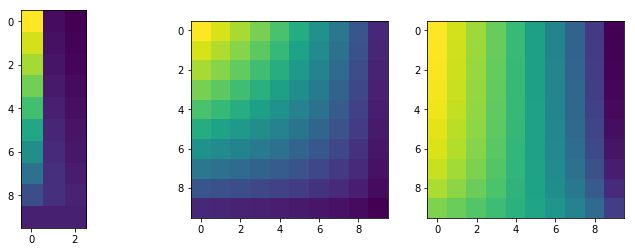

In [221]:
# plot

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(tmpSf)

plt.subplot(1,3,2)
tmptmpSfSf = tmpSf @ tmpSf.T
plt.imshow(tmptmpSfSf)

plt.subplot(1,3,3)
plt.imshow(tmptmpSfSf / np.sum(tmptmpSfSf, axis=1, keepdims=True))

plt.show()